# Analogue TV

We will strive to replicate NTSC for the true horrible colour asthetic.

In [103]:
import math
import os

import numpy as np
import PIL.Image
import scipy.interpolate
import matplotlib.pyplot as plt

%matplotlib inline

In [104]:
# Note: all times are measured in microseconds and all frequencies are measured
# in megahertz and so the scaling factors will usually cancel.

# https://www.ntsc-tv.com/ntsc-index-02.htm is a good source of timing diagrams.
# https://antiqueradio.org/art/NTSC%20Signal%20Specifications.pdf is another
# NTSC signal specification.

# How fast we sample the analogue waveform. This is the sample rate in MHz.
# In the US, analogue TV channels had a radio bandwidth of 6MHz and so, as per
# Mr Nyquist, we sample at well above twice that rate to ensure any degredation
# happens later on.
sample_rate = 32.0 # MHz

# For NTSC. Taken from https://www.avrfreaks.net/sites/default/files/ntsctime.pdf
line_time = 63.6 # µs
back_porch_time = 6.2 # µs
front_porch_time = 1.5 # µs
h_sync_time = 4.7 # µs

equalizing_pulse_time = 2.3 # µs
equalizing_pulse_period = 31.8 # µs
serration_pulse_time = 4.5 # µs
serration_pulse_period = 31.8 # µs

# For NTSC "the horizontal scanning frequency shall be 2/455 times the color subcarrier
# frequency" (https://antiqueradio.org/art/NTSC%20Signal%20Specifications.pdf)
colour_subcarrier_frequency = 455 / (2 * line_time) # MHz

# A blank line consists of a hsync pulse and black level. The active area time is
# determined by the line, sync and porch times. For NTSC is it 51.2µs.
active_time = line_time - back_porch_time - front_porch_time - h_sync_time

# Levels taken from https://www.eetimes.com/wp-content/uploads/media-1050359-c0195-figure1.gif
# Measures in "IRE" (https://en.wikipedia.org/wiki/IRE_(unit))
black_level = 0.0
white_level = 100.0
sync_level = -40.0

# Colour information
colour_carrier_amplitude = 0.5 * sync_level
colour_burst_start_time = h_sync_time + 1.0 # µs
colour_burst_time = 10 / colour_subcarrier_frequency # µs, derived from no. of cycles

# Total number of scan lines in an entire frame along with the number of active lines.
frame_total_lines = 525
frame_active_lines = 480

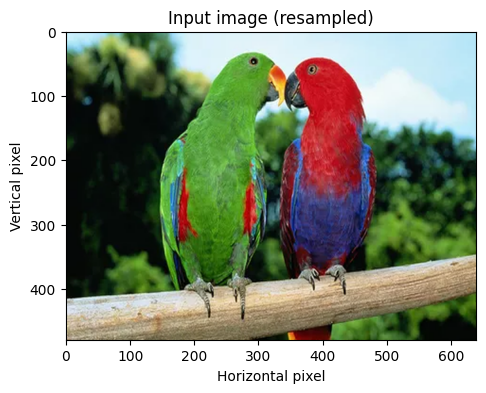

In [105]:
# Load our input image from a file. It doesn't matter what the horizontal resolution
# is but the vertical must be 480 (active) lines. To keep things visually nice, the image
# will be squished into a 4:3 aspect ratio.
#input_filename = "img/640px-SMPTE_Color_Bars.svg.png"
#input_filename = "img/testcard-f-hires.jpg"
input_filename = "img/parrots.jpg"
input_image = PIL.Image.open(input_filename).convert("RGB")
input_image = input_image.resize((int(math.ceil(4*frame_active_lines/3)), frame_active_lines), resample=PIL.Image.Resampling.LANCZOS)

head, _ = os.path.splitext(os.path.basename(input_filename))
input_image.save(os.path.join(os.path.dirname(input_filename), f"resampled-{head}.png"))

plt.figure(figsize=(8, 4))
plt.title("Input image (resampled)")
plt.xlabel("Horizontal pixel")
plt.ylabel("Vertical pixel")
plt.imshow(input_image)

In [106]:
# Firstly convert the RGB to NTSC's YUV: https://priorart.ip.com/IPCOM/000100001.
# The values lie between white level and black level.
input_array = np.asarray(input_image) / 255.

# Y is from black level to white level, I and Q are from 0 to 1
input_y = 0.3 * input_array[..., 0] + 0.59 * input_array[..., 1] + 0.11 * input_array[..., 2]
input_yiq = np.stack((
    (white_level - black_level) * input_y + black_level,
    input_array[..., 0] - input_y,  # R - Y
    input_array[..., 2] - input_y,  # B - Y
), axis=2)

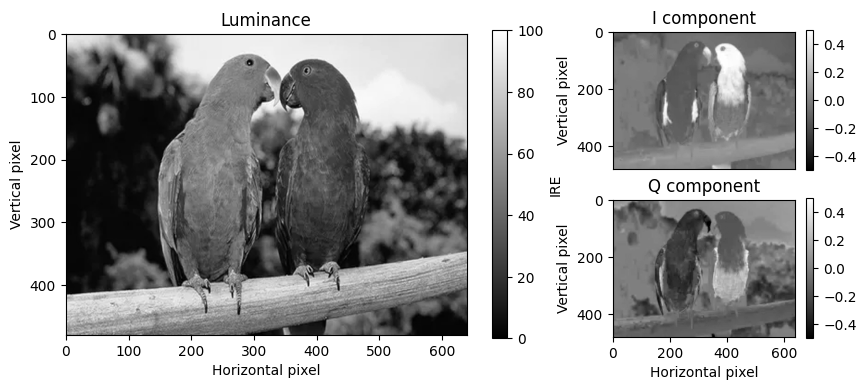

In [107]:
plt.figure(figsize=(10, 4))
lax = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
iax = plt.subplot2grid((2, 3), (0, 2))
qax = plt.subplot2grid((2, 3), (1, 2), sharex=iax)

lim = lax.imshow(input_yiq[..., 0], cmap=plt.cm.gray, clim=(black_level, white_level))
lax.set_title("Luminance")
lax.set_xlabel("Horizontal pixel")
lax.set_ylabel("Vertical pixel")
plt.colorbar(lim, ax=lax).set_label("IRE")

iim = iax.imshow(input_yiq[..., 1], cmap=plt.cm.gray, clim=(-0.5, 0.5))
iax.set_title("I component")
iax.set_ylabel("Vertical pixel")
iax.get_xaxis().set_visible(False)
plt.colorbar(iim, ax=iax)

qim = qax.imshow(input_yiq[..., 2], cmap=plt.cm.gray, clim=(-0.5, 0.5))
qax.set_title("Q component")
qax.set_ylabel("Vertical pixel")
qax.set_xlabel("Horizontal pixel")
plt.colorbar(qim, ax=qax)

Text(0.5, 1.0, 'I & Q components')

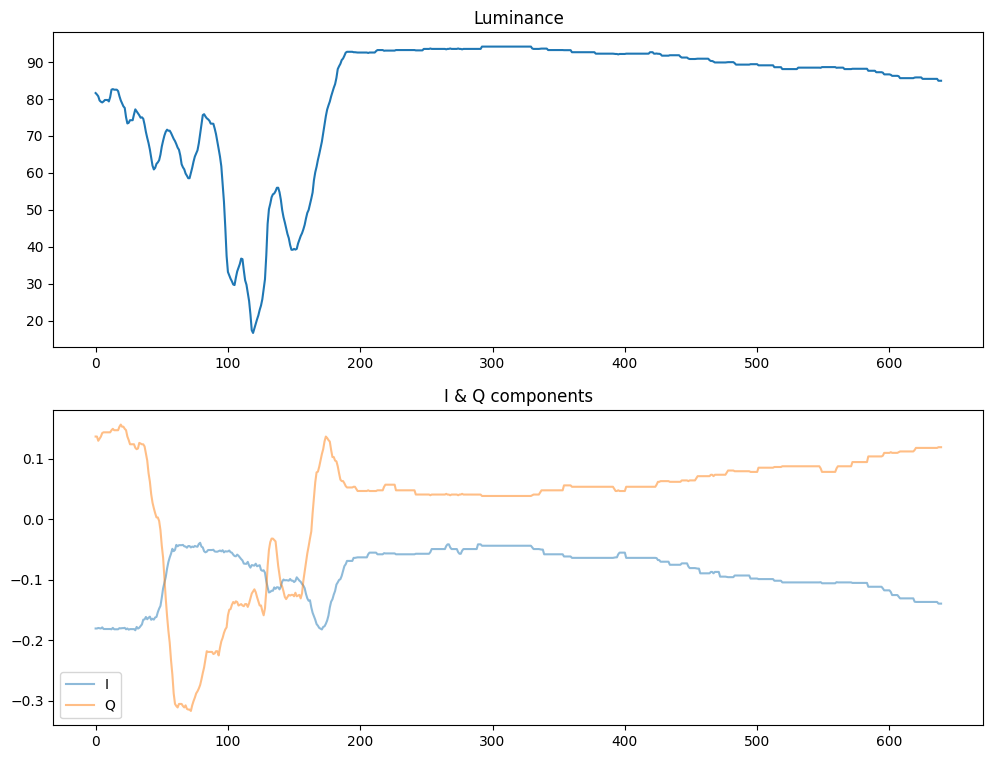

In [108]:
# Show the luminances and I/Q for a particular line.
line_idx = 20

f, (lax, iqax) = plt.subplots(2, 1, figsize=(12, 9))
lax.plot(input_yiq[line_idx, ...,  0])
lax.set_title("Luminance")
iqax.plot(input_yiq[line_idx, ..., 1], label="I", alpha=0.5)
iqax.plot(input_yiq[line_idx, ..., 2], label="Q", alpha=0.5)
iqax.legend()
iqax.set_title("I & Q components")

In [109]:
# We re-sample the input image which forms the basis of the analogue waveform's
# samples.

print(f"Input image array shape: {input_yiq.shape!r}")

# How many samples is each pixel in the input.
pixel_time = active_time / input_yiq.shape[1]
samples_per_pixel = sample_rate * pixel_time
print(f"{samples_per_pixel:.2f} samples per pixel")

# Compute (fractional) sample indices for each pixel based on sample
# rate, samples per pixel and the start sample for video data
pixel_samples = sample_rate * (h_sync_time + back_porch_time) + samples_per_pixel * np.arange(input_yiq.shape[1])

# Compute the number of samples per line and generate the re-sampled image.
# We compute an integer number of samples per line which is slightly inaccurate
# but far better than the tolerances on original equipment.
samples_per_line = int(math.ceil(line_time * sample_rate))
print(f"{samples_per_line} samples per line")
active_line_generator = scipy.interpolate.interp1d(
    pixel_samples, input_yiq, kind='quadratic', axis=1,
    fill_value=black_level, bounds_error=False
)
input_yiq_resampled = active_line_generator(np.arange(samples_per_line))

print(f"Resampled frame array shape: {input_yiq_resampled.shape!r}")

Input image array shape: (480, 640, 3)
2.56 samples per pixel
2036 samples per line
Resampled frame array shape: (480, 2036, 3)


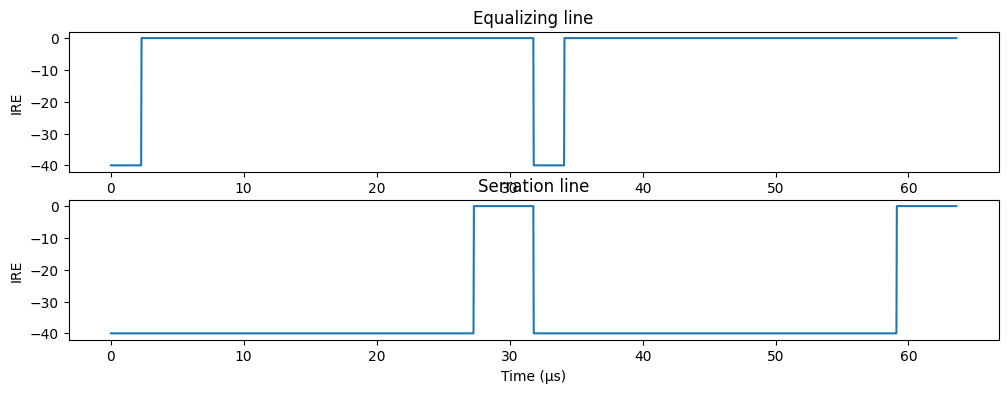

In [110]:
# Time within each line
line_times = np.arange(samples_per_line) / sample_rate

# Create equalizing and seratation pulse lines.
equalizing_line = np.where(
    np.fmod(line_times, equalizing_pulse_period) < equalizing_pulse_time,
    sync_level, black_level
)
serration_line = np.where(
    np.fmod(line_times, serration_pulse_period) >= serration_pulse_period - serration_pulse_time,
    black_level, sync_level
)

_, (ea, sa) = plt.subplots(2, 1, figsize=(12, 4))
ea.plot(line_times, equalizing_line)
ea.set_title("Equalizing line")
sa.plot(line_times, serration_line)
sa.set_title("Serration line")
for a in (ea, sa):
    a.set_xlabel("Time (µs)")
    a.set_ylabel("IRE")

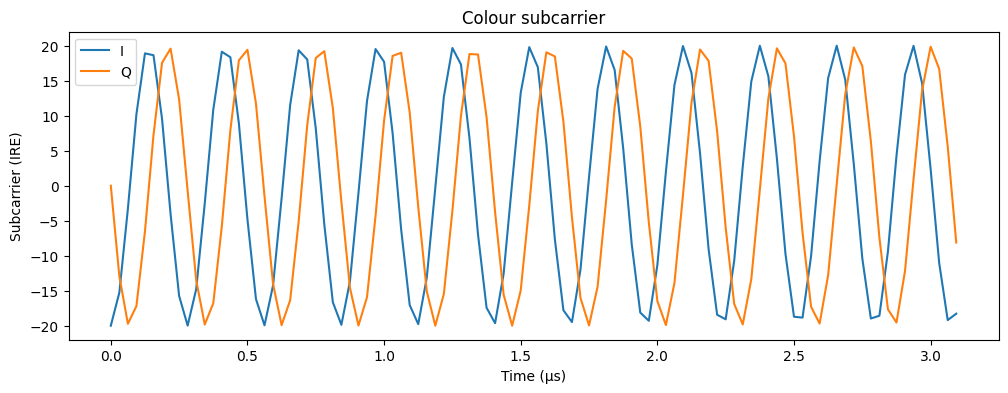

In [111]:
# Show colour subcarrier in-phase (I) and quadrature (Q) signals.
line_times = np.arange(samples_per_line) / sample_rate
colour_subcarrier = colour_carrier_amplitude * np.exp(1j * (colour_subcarrier_frequency * 2 * np.pi * line_times))
colour_i, colour_q = np.real(colour_subcarrier), np.imag(colour_subcarrier)

plt.figure(figsize=(12, 4))
plt.plot(line_times[:100], colour_i[:100], label="I")
plt.plot(line_times[:100], colour_q[:100], label="Q")
plt.xlabel("Time (µs)")
plt.ylabel("Subcarrier (IRE)")
plt.title("Colour subcarrier")
plt.legend()

In [112]:
# Pad input with non-active lines
pad_input = np.vstack((
    np.zeros((frame_total_lines - frame_active_lines,) + input_yiq_resampled.shape[1:]),
    input_yiq_resampled
))

# Set colour burst strip as being active in I channel
cb_start = math.floor(colour_burst_start_time * sample_rate)
cb_end = cb_start + math.ceil(colour_burst_time * sample_rate)
pad_input[:, cb_start:cb_end, 1] = 1

# Compute chroma subcarrier to match
n_samples = pad_input.shape[0] * pad_input.shape[1]
frame_times = np.arange(n_samples) / sample_rate
colour_subcarrier_rs = (
    colour_carrier_amplitude * np.exp(1j * (colour_subcarrier_frequency * 2 * np.pi * frame_times))
).reshape(pad_input.shape[:2])

# Start to build actual video signal by summing luminance and modulated chrominance
video_signal = (
    pad_input[..., 0] +
    np.real(colour_subcarrier_rs) * pad_input[..., 1] +
    np.imag(colour_subcarrier_rs) * pad_input[..., 2]
)

# Separate even and odd frame lines
video_signal = np.vstack((video_signal[1::2, ...], video_signal[0::2, ...]))

# Add in the hsync pulse to the luminance channel.
h_sync_n_samples = int(math.ceil(h_sync_time * sample_rate))
video_signal[:, 0:h_sync_n_samples] = sync_level

# Looking at https://www.avrfreaks.net/sites/default/files/ntsctime.pdf carefully,
# we can see which lines are have which vertical sync pulses.

# Even (first) field: lines 1-3 and 7-9 are equalizing and lines 4-6 are serration.
# Note 1-index to 0-index correction.
video_signal[[0, 1, 2, 6, 7, 8], ...] = np.repeat(equalizing_line.reshape((1, -1)), 6, axis=0)
video_signal[[3, 4, 5], ...] = np.repeat(serration_line.reshape((1, -1)), 3, axis=0)

# Odd (second) field: lines 263-265 and 270-271 are equalizing and lines 267 and 268 are serration.
# Note 1-index to 0-index correction.
video_signal[[262, 263, 264, 269, 270], ...] = np.repeat(equalizing_line.reshape((1, -1)), 5, axis=0)
video_signal[[266, 267], ...] = np.repeat(serration_line.reshape((1, -1)), 2, axis=0)

# Line 266 is half equalizing and half serration
video_signal[265] = np.hstack((
    equalizing_line[:equalizing_line.shape[0]>>1],
    serration_line[equalizing_line.shape[0]>>1:]
))

# Line 269 is the opposite
video_signal[268] = np.hstack((
    serration_line[:equalizing_line.shape[0]>>1],
    equalizing_line[equalizing_line.shape[0]>>1:]
))

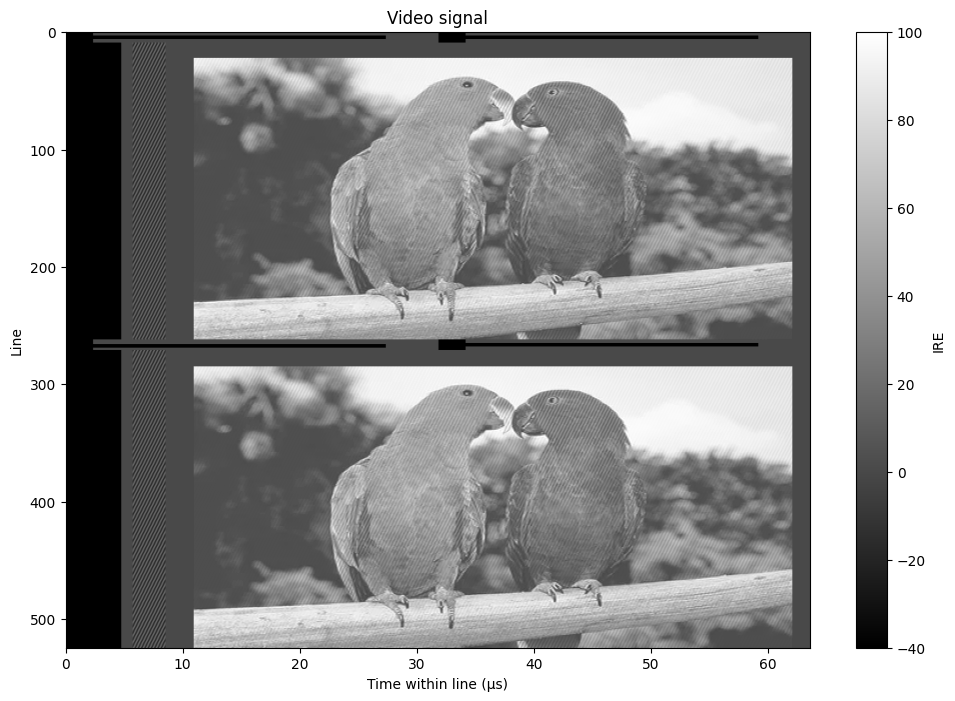

In [113]:
# Hopefully we end up with something similar to the "complete frame scan"
# shown in https://documentation.help/NI-Video-Signal-Fundamentals/documentation.pdf
# but without the insertion test lines. (Adding teletext can come at a later
# date!)

plt.figure(figsize=(12,8))
plt.imshow(
    video_signal, cmap=plt.cm.gray, clim=(sync_level, white_level),
    aspect="auto",
    extent=(0, line_time, frame_total_lines-0.5, -0.5)
)
plt.title("Video signal")
plt.ylabel("Line")
plt.xlabel("Time within line (µs)")
plt.colorbar().set_label("IRE")

In [114]:
# Save signal and sample rate to a file.
linear_signal = video_signal.reshape((-1,))
frame_time = linear_signal.shape[0] / sample_rate # µs
frame_rate = 1e6 / frame_time
np.savez_compressed("tv-signal.npz", signal=linear_signal, sample_rate=sample_rate, input_filename=input_filename)
print(f"Saved {linear_signal.shape[0]} samples covering {frame_time / 1000.0:.2f}ms or {frame_rate:.2f} frames/sec.")

Saved 1068900 samples covering 33.40ms or 29.94 frames/sec.
